# Milestone 2: Feature Ready
Team C: Andrea Natalie Natsky, Raphael Gunawan Hasudungan, Muhammad Harry Bintang Pratama
Link github: https://github.com/harry-bpm/plds_teamc
Referensi: [1] Goyal, A., Kuchana, M. & Ayyagari, K.P.R. Machine learning predicts live-birth occurrence before in-vitro fertilization treatment. Sci Rep 10, 20925 (2020). https://doi.org/10.1038/s41598-020-76928-z [2] Ratna MB, Bhattacharya S, Abdulrahim B, McLernon DJ. A systematic review of the quality of clinical prediction models in in vitro fertilisation. Hum Reprod. 2020 Jan 1;35(1):100-116. doi: 10.1093/humrep/dez258. PMID: 31960915.
           



In [1]:
pip install pyxlsb

Note: you may need to restart the kernel to use updated packages.


In [38]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn
import joblib
import io

In [39]:
tqdm.pandas()


## Cek dataset awal
LIhat apakah kedua dataset yang diberikan sama

In [40]:
df1 = pd.read_excel('E:/projects/plds_teamc/data/ar-2010-2014-xlsb.xlsb',engine='pyxlsb')
df2 = pd.read_excel('E:/projects/plds_teamc/data/ar-2015-2016-xlsb.xlsb',engine='pyxlsb')

In [4]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337109 entries, 0 to 337108
Data columns (total 95 columns):
 #   Column                                                                    Non-Null Count   Dtype  
---  ------                                                                    --------------   -----  
 0   Patient Age at Treatment                                                  337109 non-null  object 
 1   Date patient started trying to become pregnant OR date of last pregnancy  12274 non-null   float64
 2   Total Number of Previous cycles, Both IVF and DI                          337109 non-null  object 
 3   Total Number of Previous treatments, Both IVF and DI at clinic            337109 non-null  object 
 4   Total Number of Previous IVF cycles                                       337109 non-null  object 
 5   Total Number of Previous DI cycles                                        337109 non-null  object 
 6   Total number of previous pregnancies, Both IVF and D

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158519 entries, 0 to 158518
Data columns (total 95 columns):
 #   Column                                                                    Non-Null Count   Dtype  
---  ------                                                                    --------------   -----  
 0   Patient Age at Treatment                                                  158519 non-null  object 
 1   Date patient started trying to become pregnant OR date of last pregnancy  617 non-null     float64
 2   Total Number of Previous cycles, Both IVF and DI                          158519 non-null  object 
 3   Total Number of Previous treatments, Both IVF and DI at clinic            158519 non-null  object 
 4   Total Number of Previous IVF cycles                                       158519 non-null  object 
 5   Total Number of Previous DI cycles                                        158519 non-null  object 
 6   Total number of previous pregnancies, Both IVF and D

Karena kedua dataset ternyata sama (hanya berbeda di tahun saja), maka keduanya akan digabungkan sehingga rentang dataset baru dari 2010-2016

In [76]:
frames = [df1, df2]
df_combined = pd.concat(frames)

## Feature selection
Sesuai dengan PRD, ada 3 dataset yang akan dibuat: 

1.   Sesuai dengan referensi [1], digunakan fitur yang terdapat pada bagian "Without Feature Selection" 
2.   Masih memakai dengan referensi [1], dengan menggunakan LinearSVC dari dataset 1, dataset 2 akan memiliki fitur yang lebih sedikit dari dataset 1. 
3.   Menggunakan fitur dengan referensi [2].

Dari [1] dan [2], keduanya menggunakan fitur yang sama untuk semua Type of Infertility dan Cause  of Infertility. Karena semua fitur tersebut tampaknya yang paling relevan 
untuk menentukan live birth occurence. 


Dataset 1

In [7]:
selected_features_1 =["Live Birth Occurrence","Patient Age at Treatment","Total Number of Previous cycles, Both IVF and DI", "Total number of IVF pregnancies","Total number of live births - conceived through IVF","Type of Infertility - Female Primary",
"Type of Infertility - Female Secondary", "Type of Infertility - Male Primary","Type of Infertility - Male Secondary","Type of Infertility -Couple Primary","Type of Infertility -Couple Secondary",
"Cause  of Infertility - Tubal disease", "Cause of Infertility - Ovulatory Disorder","Cause of Infertility - Male Factor","Cause of Infertility - Patient Unexplained","Cause of Infertility - Endometriosis",
"Cause of Infertility - Cervical factors","Cause of Infertility - Female Factors","Cause of Infertility - Partner Sperm Concentration","Cause of Infertility -  Partner Sperm Morphology","Causes of Infertility - Partner Sperm Motility","Cause of Infertility -  Partner Sperm Immunological factors",
"Stimulation used","Egg Source","Sperm From","Fresh Cycle","Frozen Cycle","Eggs Mixed With Partner Sperm","Eggs Thawed","Embryos Transfered","Fresh Eggs Collected"]

In [17]:
dataset_1 = df_combined[selected_features_1]
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495628 entries, 0 to 158518
Data columns (total 31 columns):
 #   Column                                                       Non-Null Count   Dtype  
---  ------                                                       --------------   -----  
 0   Live Birth Occurrence                                        119210 non-null  float64
 1   Patient Age at Treatment                                     495628 non-null  object 
 2   Total Number of Previous cycles, Both IVF and DI             495628 non-null  object 
 3   Total number of IVF pregnancies                              495628 non-null  object 
 4   Total number of live births - conceived through IVF          495628 non-null  int64  
 5   Type of Infertility - Female Primary                         495628 non-null  int64  
 6   Type of Infertility - Female Secondary                       495628 non-null  int64  
 7   Type of Infertility - Male Primary                           4956

Feature Engineering
Ubah teks dan umur pada fitur menjadi categorical data.  
*   Patient Age at Treatment: Buang baris yang tidak dalam range. Konversi umur: 18-34=0, 35-37=1, 38-39=2, 40-42=3, 43-44=4, 45-50=5
*   Sperm From dan Egg source: Patient, Partner=1.  Donor, Partner & Donor = 0  
*   Stimulation used: buang data jika nilai 0



In [18]:
dataset_1 = dataset_1.dropna(subset = ["Egg Source","Sperm From"])
dataset_1["Live Birth Occurrence"]=dataset_1["Live Birth Occurrence"].fillna(0)
dataset_1 = dataset_1[dataset_1['Stimulation used'] != 0]
#Convert patient age to categorical data
dataset_1 = dataset_1[dataset_1['Patient Age at Treatment'] != "999"]
dataset_1["Patient Age at Treatment"] = dataset_1["Patient Age at Treatment"].str.replace(" ","")
#dataset_1["Patient Age at Treatment"] = dataset_1["Patient Age at Treatment"].str.replace("18-34","0")
#dataset_1["Patient Age at Treatment"] = dataset_1["Patient Age at Treatment"].str.replace("35-37","1")
#dataset_1["Patient Age at Treatment"] = dataset_1["Patient Age at Treatment"].str.replace("38-39","2")
#dataset_1["Patient Age at Treatment"] = dataset_1["Patient Age at Treatment"].str.replace("40-42","3")
#dataset_1["Patient Age at Treatment"] = dataset_1["Patient Age at Treatment"].str.replace("43-44","4")
#dataset_1["Patient Age at Treatment"] = dataset_1["Patient Age at Treatment"].str.replace("44-50","5")

dataset_1 = dataset_1.replace({"Patient Age at Treatment":{"18-34":"0", "35-37":"1" ,"38-39": "2","40-42": "3", "43-44": "4","45-50": "5"}})

dataset_1 = dataset_1.replace("> 50","50")
dataset_1 = dataset_1.replace(">=5","5")



In [19]:
dataset_1['Patient Age at Treatment'].unique()

array(['0', '2', '3', '1', '4', '5'], dtype=object)

In [103]:

dataset_1 = dataset_1.replace("Patient","1")
dataset_1 = dataset_1.replace("Partner","1")
dataset_1 = dataset_1.replace("Donor","0")
dataset_1 = dataset_1.replace("Partner & Donor","0")
dataset_1 = dataset_1[dataset_1["Sperm From"].str.contains("not assigned")==False]

Splitting: bagi dataframe menjadi data (X) dan target data (y). Lalu bagi tiap X dan Y untuk training 70% dan testing 30%.

In [104]:
dataset_1_X = dataset_1.loc[:, dataset_1.columns != "Live Birth Occurrence"]
dataset_1_Y = dataset_1["Live Birth Occurrence"]
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(dataset_1_X, dataset_1_Y, test_size=0.3, random_state=42)

simpan dataset 1

In [116]:
import pickle 
with open('E:/projects/plds_teamc/data/dataset_1.pickle', 'wb') as output:
    pickle.dump(dataset_1, output)

Tampilkan correlation matrix dari fitur pada dataset 1

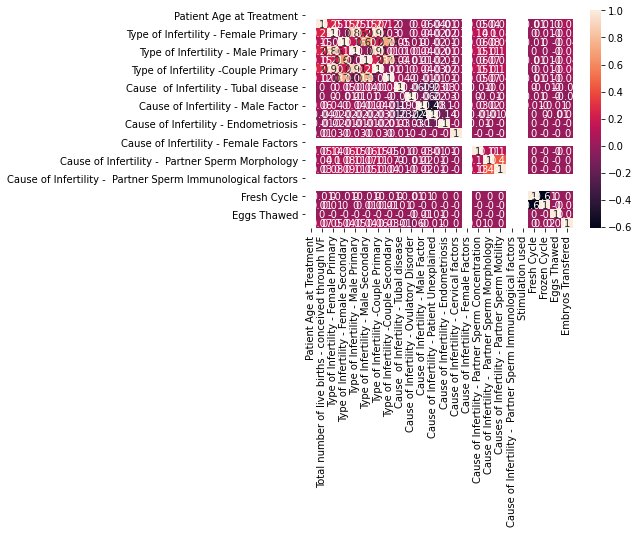

In [89]:
corr_mat1 = dataset_1_X.corr().round(2)
sns.heatmap(corr_mat1, annot=True)
plt.show()

Dataset 2
Menggunakan fitur dari dataset 1, buat dataset baru dengan linearSVC untuk mengurangi jumlah fitur

In [106]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(dataset_1_X, dataset_1_Y)
model = SelectFromModel(lsvc, prefit=True)
dataset_2_X = model.transform(dataset_1_X)



Splitting: bagi dataframe menjadi data (X) dan target data (y). Lalu bagi tiap X dan Y untuk training 70% dan testing 30%.

In [107]:
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(dataset_2_X, dataset_1_Y, test_size=0.3, random_state=42)

simpan dataset 2

In [115]:
with open('E:/projects/plds_teamc/data/dataset_2.pickle', 'wb') as output:
    pickle.dump(dataset_2_X, output)

Dataset 3.
Cara yang sama dengan dataset 1, hanya berbeda dari fitur yang dipakai

In [157]:
selected_features_2 =["Live Birth Occurrence","Patient Age at Treatment", "Total Number of Previous treatments, Both IVF and DI at clinic", "Total Number of Previous IVF cycles","Total number of IVF pregnancies","Type of Infertility - Female Primary",
"Type of Infertility - Female Secondary", "Type of Infertility - Male Primary","Type of Infertility - Male Secondary","Type of Infertility -Couple Primary","Type of Infertility -Couple Secondary",
"Cause  of Infertility - Tubal disease", "Cause of Infertility - Ovulatory Disorder","Cause of Infertility - Male Factor","Cause of Infertility - Patient Unexplained","Cause of Infertility - Endometriosis",
"Cause of Infertility - Cervical factors","Cause of Infertility - Female Factors","Cause of Infertility - Partner Sperm Concentration","Cause of Infertility -  Partner Sperm Morphology","Causes of Infertility - Partner Sperm Motility","Cause of Infertility -  Partner Sperm Immunological factors",
"Stimulation used","Embryos Transfered","Type of treatment - IVF or DI","Specific treatment type","Total Embryos Created" ]

In [158]:
dataset_3 = df_combined[selected_features_2]
#dataset_3.info()

In [159]:
dataset_3 = dataset_3[dataset_3['Stimulation used'] != 0]
dataset_3=dataset_3.drop(columns=['Stimulation used'])
#Convert patient age to categorical data
dataset_3 = dataset_3[dataset_3['Patient Age at Treatment'] != "999"]
dataset_3["Patient Age at Treatment"] = dataset_3["Patient Age at Treatment"].str.replace(" ","")
dataset_3 = dataset_3.replace({"Patient Age at Treatment":{"18-34":"0", "35-37":"1" ,"38-39": "2","40-42": "3", "43-44": "4","45-50": "5"}})
dataset_3["Patient Age at Treatment"] = pd.to_numeric(dataset_3['Patient Age at Treatment'])

dataset_3 = dataset_3.replace({"Total Number of Previous treatments, Both IVF and DI at clinic":{"0":"0", "1":"1" ,"2": "2","3": "3", "4": "4","5": "5",">=5": "6"}})
dataset_3["Total Number of Previous treatments, Both IVF and DI at clinic"] = pd.to_numeric(dataset_3['Total Number of Previous treatments, Both IVF and DI at clinic'])

dataset_3 = dataset_3.replace({"Total Number of Previous IVF cycles":{"0":"0", "1":"1" ,"2": "2","3": "3", "4": "4","5": "5",">=5": "6"}})
dataset_3["Total Number of Previous IVF cycles"] = pd.to_numeric(dataset_3['Total Number of Previous IVF cycles'])
dataset_3["Total number of IVF pregnancies"] = pd.to_numeric(dataset_3['Total number of IVF pregnancies'])

dataset_3= dataset_3[dataset_3["Embryos Transfered"].notna()]
dataset_3["Embryos Transfered"] = pd.to_numeric(dataset_3['Embryos Transfered'])

dataset_3=dataset_3.drop(columns=['Type of treatment - IVF or DI'])
dataset_3= dataset_3[dataset_3["Total Embryos Created"].notna()]

dataset_3 = dataset_3.loc[dataset_3["Specific treatment type"].isin(["IVF", "ICSI", "ICSI:IVF","IVF:ICSI" ])]
dataset_3['Live Birth Occurrence'] = dataset_3['Live Birth Occurrence'].fillna(0)
dataset_3=dataset_3.drop(columns=['Specific treatment type"'])

#dataset_3 = dataset_3[dataset_3['Specific treatment type'] == "IVF"]
#dataset_3 = dataset_3[dataset_3['Specific treatment type'] == "ICSI"]
#dataset_3 = dataset_3[dataset_3['Specific treatment type'] == "ICSI:IVF"]
#dataset_3 = dataset_3[dataset_3['Specific treatment type'] == "IVF:ICSI"]

#dataset_3 = dataset_3.replace({"Total Number of Previous IVF cycles":{"0":"0", "1":"1" ,"2": "2","3": "3", "4": "4","5": "5",">=5": "6"}})
#ICSI' 'IVF' 'ICSI / AH' 'IVF / AH' 'ICSI / BLASTOCYST
#dataset_3 = dataset_3.replace("> 50","50")
#dataset_3 = dataset_3.replace(">=5","5")
#dataset_3 = dataset_3.replace("Patient","1")
#dataset_3 = dataset_3.replace("Partner","1")
#dataset_3 = dataset_3.replace("Donor","0")
#dataset_3 = dataset_3.replace("Partner & Donor","0")


In [150]:
dataset_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333620 entries, 8218 to 148105
Data columns (total 25 columns):
 #   Column                                                          Non-Null Count   Dtype  
---  ------                                                          --------------   -----  
 0   Live Birth Occurrence                                           333620 non-null  float64
 1   Patient Age at Treatment                                        333620 non-null  int64  
 2   Total Number of Previous treatments, Both IVF and DI at clinic  333620 non-null  int64  
 3   Total Number of Previous IVF cycles                             333620 non-null  int64  
 4   Total number of IVF pregnancies                                 333620 non-null  int64  
 5   Type of Infertility - Female Primary                            333620 non-null  int64  
 6   Type of Infertility - Female Secondary                          333620 non-null  int64  
 7   Type of Infertility - Male Primary 

In [108]:
print("Specific treatment type",":",dataset_3["Specific treatment type"].unique())

Specific treatment type : ['ICSI' 'IVF' 'ICSI / AH' 'IVF / AH' 'ICSI / BLASTOCYST '
 'IVF / BLASTOCYST' 'IVF / AH:ICSI / AH' 'ICSI:ICSI' 'IVF:ICSI' 'ICSI:IVF'
 'ICSI:Unknown' 'IVF:IVF' 'Unknown' 'IVF:Unknown'
 'ICSI / BLASTOCYST:IVF / BLASTOCYST' nan 'ICSI / AH:Unknown'
 'ICSI / BLASTOCYST :IVF / BLASTOCYST' 'GIFT' 'FER'
 'IVF:Unknown:Unknown:Unknown']


In [160]:
dataset_3

,Live Birth Occurrence,Patient Age at Treatment,"Total Number of Previous treatments, Both IVF and DI at clinic",Total Number of Previous IVF cycles,Total number of IVF pregnancies,Type of Infertility - Female Primary,Type of Infertility - Female Secondary,Type of Infertility - Male Primary,Type of Infertility - Male Secondary,Type of Infertility -Couple Primary,...,Cause of Infertility - Endometriosis,Cause of Infertility - Cervical factors,Cause of Infertility - Female Factors,Cause of Infertility - Partner Sperm Concentration,Cause of Infertility - Partner Sperm Morphology,Causes of Infertility - Partner Sperm Motility,Cause of Infertility - Partner Sperm Immunological factors,Embryos Transfered,Specific treatment type,Total Embryos Created
8218,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,ICSI,14
8219,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,IVF,2
8220,0.0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,IVF,3
8222,0.0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,ICSI,2
8223,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,ICSI,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148101,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,IVF,2
148102,1.0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,ICSI,4
148103,0.0,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2.0,IVF,4
148104,0.0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.0,IVF,6


In [161]:
selected_features_2 =["Live Birth Occurrence","Patient Age at Treatment", "Total Number of Previous treatments, Both IVF and DI at clinic", "Total Number of Previous IVF cycles","Total number of IVF pregnancies","Type of Infertility - Female Primary",
"Type of Infertility - Female Secondary", "Type of Infertility - Male Primary","Type of Infertility - Male Secondary","Type of Infertility -Couple Primary","Type of Infertility -Couple Secondary",
"Cause  of Infertility - Tubal disease", "Cause of Infertility - Ovulatory Disorder","Cause of Infertility - Male Factor","Cause of Infertility - Patient Unexplained","Cause of Infertility - Endometriosis",
"Cause of Infertility - Cervical factors","Cause of Infertility - Female Factors","Cause of Infertility - Partner Sperm Concentration","Cause of Infertility -  Partner Sperm Morphology","Causes of Infertility - Partner Sperm Motility","Cause of Infertility -  Partner Sperm Immunological factors",
"Embryos Transfered","Specific treatment type","Total Embryos Created" ]

In [162]:
for feat in selected_features_2:
    print(feat,":",dataset_3[feat].unique())

Live Birth Occurrence : [0. 1.]
Patient Age at Treatment : [0 2 3 1 4 5]
Total Number of Previous treatments, Both IVF and DI at clinic : [0 2 1 4 6 3 5]
Total Number of Previous IVF cycles : [0 1 3 4 6 2 5]
Total number of IVF pregnancies : [0 1 2 3 5 4]
Type of Infertility - Female Primary : [0 1]
Type of Infertility - Female Secondary : [0 1]
Type of Infertility - Male Primary : [0 1]
Type of Infertility - Male Secondary : [0 1]
Type of Infertility -Couple Primary : [0 1]
Type of Infertility -Couple Secondary : [0 1]
Cause  of Infertility - Tubal disease : [0 1]
Cause of Infertility - Ovulatory Disorder : [0 1]
Cause of Infertility - Male Factor : [1 0]
Cause of Infertility - Patient Unexplained : [0 1]
Cause of Infertility - Endometriosis : [0 1]
Cause of Infertility - Cervical factors : [0 1]
Cause of Infertility - Female Factors : [0]
Cause of Infertility - Partner Sperm Concentration : [0 1]
Cause of Infertility -  Partner Sperm Morphology : [0 1]
Causes of Infertility - Partner

Splitting: bagi dataframe menjadi data (X) dan target data (y). Lalu bagi tiap X dan Y untuk training 70% dan testing 30%.

In [23]:
dataset_3_X = dataset_3.loc[:, dataset_3.columns != "Live Birth Occurrence"]
dataset_3_Y = dataset_3["Live Birth Occurrence"]
from sklearn.model_selection import train_test_split
X_train_3, X_test_3, Y_train_3, Y_test_3 = train_test_split(dataset_3_X, dataset_3_Y, test_size=0.3, random_state=42)

In [28]:
joblib.dump(X_train_3, "E:\\projects\\plds_teamc\\output\\X_train_3.pkl")
joblib.dump(X_test_3,"E:\\projects\\plds_teamc\\output\\X_test_3.pkl")
joblib.dump(Y_train_3,"E:\\projects\\plds_teamc\\output\\Y_train_3.pkl")
joblib.dump(Y_test_3,"E:\\projects\\plds_teamc\\output\\Y_test_3.pkl")

['E:\\projects\\plds_teamc\\output\\Y_test_3.pkl']

Tampilkan correlation matrix dari fitur pada dataset 3

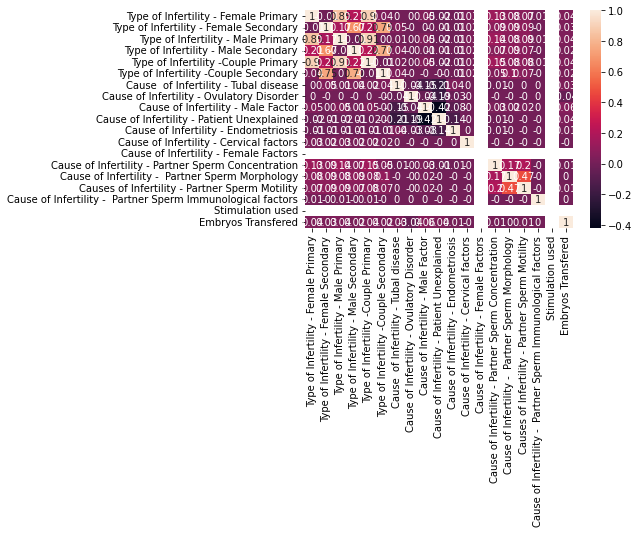

In [24]:
corr_mat3 = dataset_3_X.corr().round(2)
sns.heatmap(corr_mat3, annot=True)
plt.show()

simpan dataset 2

In [26]:
import pickle
with open('E:/projects/plds_teamc/data/dataset_3.pickle', 'wb') as output:
    pickle.dump(dataset_3, output)